In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import h5py
import pandas as pd

from tqdm import tqdm_notebook as tqdm

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
mpl.rcParams.update(params)
plt.jet()

method = "Forest"
classes = np.array(['Peaks','Filaments','Sheets','Voids'])
np.set_printoptions(precision = 4)

<Figure size 1080x360 with 0 Axes>

In [2]:
path = './data/'

### Sci-kit learn packages

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

### Train test valid spliter function

In [4]:
def train_test_valid_split(X,Y,train_size,test_size,valid_size,random_state,by_class):
    if train_size+test_size+valid_size == 1:
        if by_class==True:
            
            X_train_g = pd.DataFrame()
            X_test_g  = pd.DataFrame()
            X_valid_g = pd.DataFrame()
            Y_train_g = pd.DataFrame()
            Y_test_g  = pd.DataFrame()
            Y_valid_g = pd.DataFrame()
            
            for i in np.unique(Y):
                X_train, X_valid_test, Y_train, Y_valid_test = train_test_split( X[Y['env']==i], Y[Y['env']==i], train_size=train_size, test_size=1-train_size, random_state=random_state)
                X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid_test, Y_valid_test, train_size=valid_size/train_size, test_size=test_size/train_size, random_state=random_state)
                
                X_train_g = X_train_g.append([X_train], ignore_index=True)
                X_test_g  = X_test_g.append([X_test], ignore_index=True)
                X_valid_g = X_valid_g.append([X_valid], ignore_index=True)
                Y_train_g = Y_train_g.append([Y_train], ignore_index=True)
                Y_test_g  = Y_test_g.append([Y_test], ignore_index=True)
                Y_valid_g = Y_valid_g.append([Y_valid], ignore_index=True)
                                               
            return X_train_g, X_test_g, X_valid_g, Y_train_g, Y_test_g, Y_valid_g
        else:
            X_train, X_valid_test, Y_train, Y_valid_test = train_test_split(X, Y, train_size=train_size, test_size=1-train_size, random_state=random_state)
            X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid_test, Y_valid_test, train_size=valid_size/train_size, test_size=test_size/train_size, random_state=random_state)
            return X_train, X_test, X_valid, Y_train, Y_test, Y_valid
    else:
        "It's not possible. -> train_size+test_size+valid_size=1"
 

In [5]:
#------------ Best model Random Forest
MD = 10 # Max Depth for the trees in the Random Forest algorithm
NE = 80 # Number of Estimators (trees) in the Random Forest algorithm

#------------ Reading Bsk catalog
filename = path+'example_features.h5' # Filename with the features for the RF algorithm
f = h5py.File(filename, 'r')
headers = list(f.keys())
print(headers)
ID = np.array(f['ID'])
nc = np.array(f['nc'])
ad = np.array(f['ad'])
ra = np.array(f['ra'])
den = np.array(f['den'])
Dnc = np.array(f['Dnc'])
Dad = np.array(f['Dad'])
Dra = np.array(f['Dra'])
Dden = np.array(f['Dden'])
f.close()

#------------ Reading the mock catalog to extract environments            
filename = path+'example_mock.hdf5'
f = h5py.File(filename, 'r')
headers=list(f.keys())
env_pot = np.array(f['environment']) # 3 void, 2 sheet, 1 filament, 0 peak
x = np.array(f['x']) 
y = np.array(f['y']) 
z = np.array(f['z'])
f.close()

classes = np.array(['Peaks','Filaments','Sheets','Voids'])
np.set_printoptions(precision=4)
       
#------------ Defining the features space and making train,test,vaid split
Xdata = pd.DataFrame({'ad':ad,'nc':nc,'ra':ra,'den':den,'Dad':Dad,'Dnc':Dnc,'Dra':Dra,'Dden':Dden,'x':x,'y':y, 'z':z}) #
Ydata = pd.DataFrame({'env':env_pot})
X_train, X_test, X_valid, Y_train, Y_test , Y_valid = train_test_valid_split(Xdata, Ydata, train_size=0.5, test_size=0.3, valid_size=0.2, random_state=0, by_class=True)

Pos_valid = X_valid[X_valid.columns[-3:]]
Pos_train = X_train[X_train.columns[-3:]]

X_valid = X_valid[X_valid.columns[:-3]]
X_train = X_train[X_train.columns[:-3]]

#---------------------------------
Xdata = pd.DataFrame({'ad':ad,'nc':nc,'ra':ra,'den':den,'Dad':Dad,'Dnc':Dnc,'Dra':Dra,'Dden':Dden})
Ydata = pd.DataFrame({'env':env_pot})

['Dabc', 'Dad', 'Dden', 'Dnc', 'Dra', 'ID', 'abc', 'ad', 'con', 'coor', 'den', 'nc', 'ra', 'vol']


In [6]:
X_train, X_test, X_valid, Y_train, Y_test , Y_valid = train_test_valid_split(Xdata, Ydata, train_size=0.5, test_size=0.3, valid_size=0.2, random_state=1, by_class=True)
Y_valid = np.array(Y_valid).flatten()

#------------ Removing borders
xx = (Pos_train['x'] > 5) & (Pos_train['x'] < 295)
yy = (Pos_train['y'] > 5) & (Pos_train['y'] < 295)

#------------ Applying the filter
X_train = X_train[xx & yy]
Y_train = Y_train[xx & yy]

/home/debian/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


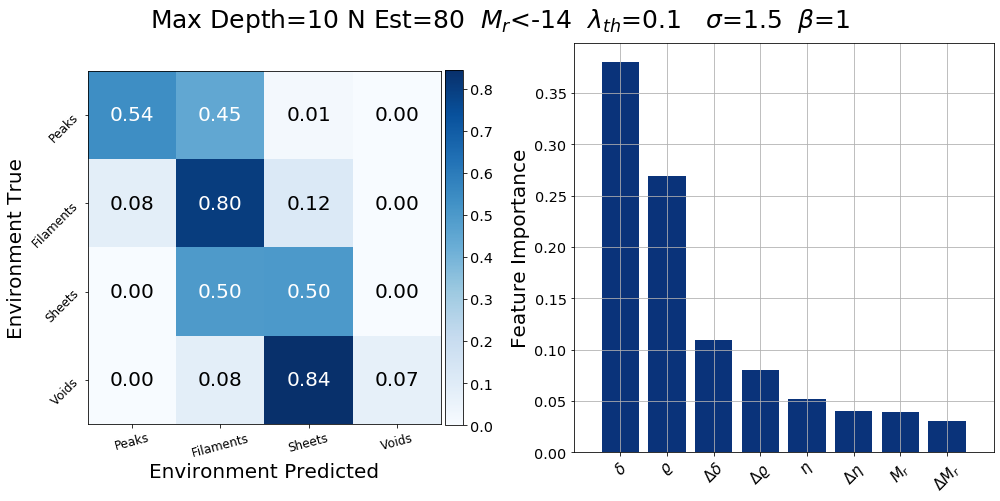

In [7]:
fig= plt.figure(figsize=(14,7))

clf = RandomForestClassifier(max_depth = MD, n_estimators = NE)
clf.fit(X_train,Y_train)

Y_pred = clf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
classes = classes[unique_labels(Y_valid, Y_pred)]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = fig.add_subplot(1,2,1)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.74)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Environment Predicted",size=20)
ax.set_ylabel("Environment True",size=20)
ax.set_ylim(4-0.5, -0.5)

plt.setp(ax.get_xticklabels(), rotation=15, size=12)
plt.setp(ax.get_yticklabels(), rotation=45, size=12)

fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")

#------------ Feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

lfi=len(importances)
features=np.array(list(['ad','nc','ra','den','Dad','Dnc','Dra','Dden']))
features_tex=["$\delta$","$\eta$","$M_{r}$",r'$\varrho$',"$\Delta \delta$","$\Delta \eta$","$\Delta M_{r}$",r'$\Delta \varrho$']


#------------ Plot the feature importances
ax = fig.add_subplot(1,2,2,aspect=22,rasterized=True)
plt.bar(range(lfi), importances[indices], color="#0a337a", align="center")
plt.xticks(range(lfi), list(np.array(features_tex)[indices]), rotation=45, size=15)
plt.grid()
plt.ylabel("Feature Importance",size=20)
plt.xlim([-1, lfi])

fig.suptitle('Max Depth='+str(MD)+' N Est='+str(NE)+'  $M_{r}$<-14  $\lambda_{th}$=0.1   $\sigma$=1.5  $\\beta$=1',size=25)
fig.subplots_adjust(top=0.97)
fig.tight_layout()

plt.show()

###  For plot the LSS

In [8]:
NLoops = 10
D = int(np.shape(X_valid)[0]/NLoops)

xx_pred_void = []
xx_pred_fila = []
xx_pred_peak = []
xx_pred_sheet = []

xx_valid_void = []
xx_valid_fila = []
xx_valid_peak = []
xx_valid_sheet = []

yy_pred_void = []
yy_pred_fila = []
yy_pred_peak = []
yy_pred_sheet = []

yy_valid_void = []
yy_valid_fila = []
yy_valid_peak = []
yy_valid_sheet = []

for i in range(NLoops):
    Xx_valid = X_valid[i*D:(i+1)*D]
    Yy_valid = Y_valid[i*D:(i+1)*D]
    pos_valid = Pos_valid[i*D:(i+1)*D]

    Yy_pred = clf.predict(Xx_valid)
        
    zlim = 50
    
    if np.sum((Yy_pred==3) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_pred_void.append(np.array(pos_valid['x'])[(Yy_pred==3) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_void.append(np.array(pos_valid['y'])[(Yy_pred==3) & (np.array(pos_valid['z'])<zlim)] )
    
    if np.sum((Yy_pred==2) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_pred_sheet.append(np.array(pos_valid['x'])[(Yy_pred==2) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_sheet.append(np.array(pos_valid['y'])[(Yy_pred==2) & (np.array(pos_valid['z'])<zlim)])      
        
    if np.sum((Yy_pred==1) & (np.array(pos_valid['z'])<zlim) ) != 0:
        xx_pred_fila.append(np.array(pos_valid['x'])[(Yy_pred==1) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_fila.append(np.array(pos_valid['y'])[(Yy_pred==1) & (np.array(pos_valid['z'])<zlim)])
        
    if np.sum((Yy_pred==0) & (np.array(pos_valid['z'])<zlim)) !=0:
        xx_pred_peak.append(np.array(pos_valid['x'])[(Yy_pred==0) & (np.array(pos_valid['z'])<zlim)])
        yy_pred_peak.append(np.array(pos_valid['y'])[(Yy_pred==0) & (np.array(pos_valid['z'])<zlim)])

    if np.sum((Yy_valid ==3) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_void.append(np.array(pos_valid['x'])[(Yy_valid ==3) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_void.append(np.array(pos_valid['y'])[(Yy_valid ==3) & (np.array(pos_valid['z'])<zlim)])       
        
    if np.sum((Yy_valid ==2) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_sheet.append(np.array(pos_valid['x'])[(Yy_valid ==2) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_sheet.append(np.array(pos_valid['y'])[(Yy_valid ==2) & (np.array(pos_valid['z'])<zlim)])   

    if np.sum((Yy_valid ==1) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_fila.append(np.array(pos_valid['x'])[(Yy_valid ==1) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_fila.append(np.array(pos_valid['y'])[(Yy_valid ==1) & (np.array(pos_valid['z'])<zlim)])
        
    if np.sum((Yy_valid ==0) & (np.array(pos_valid['z'])<zlim)) != 0:
        xx_valid_peak.append(np.array(pos_valid['x'])[(Yy_valid ==0) & (np.array(pos_valid['z'])<zlim)])
        yy_valid_peak.append(np.array(pos_valid['y'])[(Yy_valid ==0) & (np.array(pos_valid['z'])<zlim)])
        
xx_pred_void = np.concatenate(xx_pred_void).flatten()
xx_pred_fila = np.concatenate(xx_pred_fila).flatten()
xx_pred_peak = np.concatenate(xx_pred_peak).flatten()
xx_pred_sheet = np.concatenate(xx_pred_sheet).flatten()

xx_valid_void = np.concatenate(xx_valid_void).flatten()
xx_valid_fila = np.concatenate(xx_valid_fila).flatten()
xx_valid_peak = np.concatenate(xx_valid_peak).flatten()
xx_valid_sheet = np.concatenate(xx_valid_sheet).flatten()

yy_pred_void = np.concatenate(yy_pred_void).flatten()
yy_pred_fila = np.concatenate(yy_pred_fila).flatten()
yy_pred_peak = np.concatenate(yy_pred_peak).flatten()
yy_pred_sheet = np.concatenate(yy_pred_sheet).flatten()

yy_valid_void = np.concatenate(yy_valid_void).flatten()
yy_valid_fila = np.concatenate(yy_valid_fila).flatten()
yy_valid_peak = np.concatenate(yy_valid_peak).flatten()
yy_valid_sheet = np.concatenate(yy_valid_sheet).flatten()    

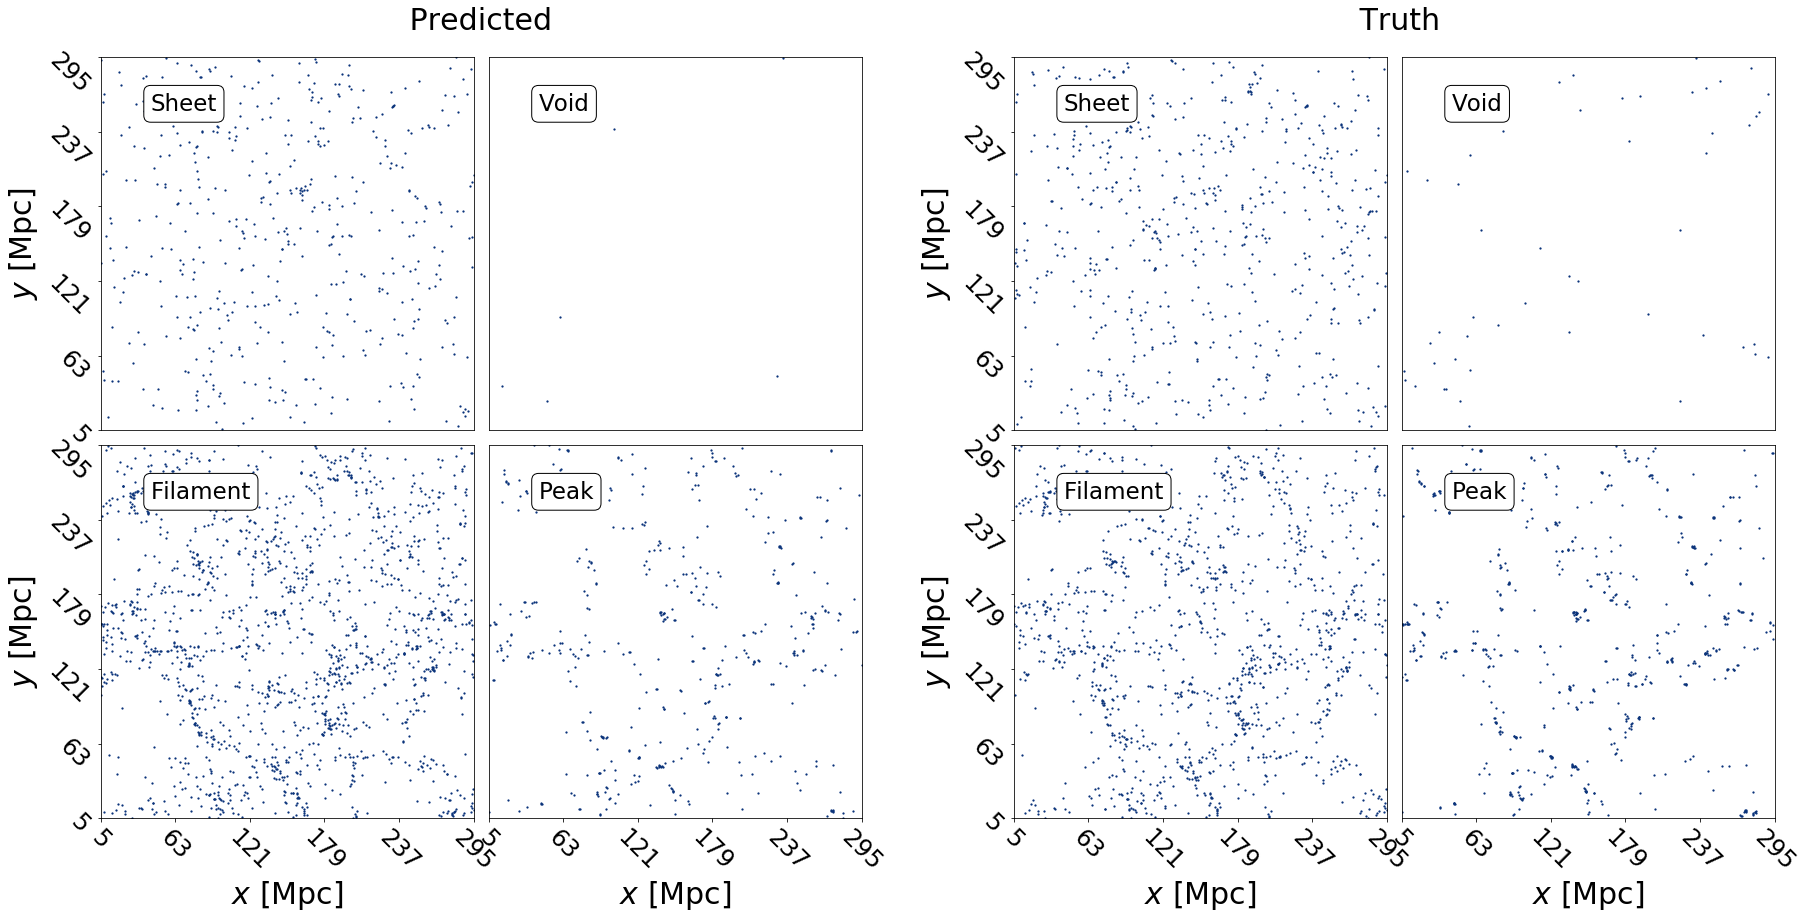

In [9]:
ii = (xx_pred_void > 5) & (xx_pred_void < 295) & (yy_pred_void > 5) & (yy_pred_void < 295)
xx_pred_void = xx_pred_void[ii]
yy_pred_void = yy_pred_void[ii]

ii = (xx_pred_fila > 5) & (xx_pred_fila < 295) & (yy_pred_fila > 5) & (yy_pred_fila < 295)
xx_pred_fila = xx_pred_fila[ii]
yy_pred_fila = yy_pred_fila[ii]

ii = (xx_pred_peak > 5) & (xx_pred_peak < 295) & (yy_pred_peak > 5) & (yy_pred_peak < 295)
xx_pred_peak = xx_pred_peak[ii]
yy_pred_peak = yy_pred_peak[ii]

ii = (xx_pred_sheet > 5) & (xx_pred_sheet < 295) & (yy_pred_sheet > 5) & (yy_pred_sheet < 295)
xx_pred_sheet = xx_pred_sheet[ii]
yy_pred_sheet = yy_pred_sheet[ii]

ii = (xx_valid_void > 5) & (xx_valid_void < 295) & (yy_valid_void > 5) & (yy_valid_void < 295)
xx_valid_void = xx_valid_void[ii]
yy_valid_void = yy_valid_void[ii]

ii = (xx_valid_fila > 5) & (xx_valid_fila < 295) & (yy_valid_fila > 5) & (yy_valid_fila < 295)
xx_valid_fila = xx_valid_fila[ii]
yy_valid_fila = yy_valid_fila[ii]

ii = (xx_valid_peak > 5) & (xx_valid_peak < 295) & (yy_valid_peak > 5) & (yy_valid_peak < 295)
xx_valid_peak = xx_valid_peak[ii]
yy_valid_peak = yy_valid_peak[ii]

ii = (xx_valid_sheet > 5) & (xx_valid_sheet < 295) & (yy_valid_sheet > 5) & (yy_valid_sheet < 295)
xx_valid_sheet = xx_valid_sheet[ii]
yy_valid_sheet = yy_valid_sheet[ii]

Yyy = [yy_pred_sheet,yy_pred_void,yy_valid_sheet,yy_valid_void,yy_pred_fila,yy_pred_peak,yy_valid_fila,yy_valid_peak]
Xxx = [xx_pred_sheet,xx_pred_void,xx_valid_sheet,xx_valid_void,xx_pred_fila,xx_pred_peak,xx_valid_fila,xx_valid_peak]
ENV = ['Sheet','Void','Sheet','Void','Filament','Peak','Filament','Peak']

fig = plt.figure(figsize=(30, 14))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.04)

ss =  1.5
ii = 0

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(1,2,
                    subplot_spec=outer[i], wspace=0.04, hspace=0.04)
    
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        ax.scatter(Xxx[ii],Yyy[ii],s=ss, c='#0a337a', rasterized=True)
        ax.set_xlabel("$x$ [Mpc]",size=30)
        ax.set_ylabel("$y$ [Mpc]",size=30)
        ax.set_xlim(5,295)
        ax.set_ylim(5,295)
        ax.tick_params(axis='both', labelsize=24)
        ax.xaxis.set_ticks(np.arange(5, 305, 58))
        ax.yaxis.set_ticks(np.arange(5, 305, 58))
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45 )
        plt.setp( ax.yaxis.get_majorticklabels(), rotation=-45 )
        ax.annotate(ENV[ii], xy=(50, 320), xycoords='axes points',
            size=23,bbox=dict(boxstyle='round', fc='w'))
        
        fig.add_subplot(ax)
        if (ii == 1) or (ii == 3) or (ii == 5) or (ii == 7):
            plt.setp(ax.get_yaxis(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
        if (ii == 0) or (ii == 1) or (ii == 2) or (ii == 3):
            plt.setp(ax.get_xaxis(), visible=False)
            plt.setp(ax.get_xticklabels(), visible=False)
        
        ii += 1
        

plt.suptitle(r'   Predicted                                                                                     Truth',y=0.93,size=30)
plt.show()